# Create consolidated shapefile with all the variable information needed
aka, including population, gdp, yields, etc. 

Also a good place to create a clearinghouse for quality checking (i.e. VA FIPS)

In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
import re
from aux_funcs import get_params

## Process

In [6]:
data = dict()
# Load geographic data
data['counties']  = gpd.read_file(dir_list['geo']+'cb_2018_us_county_20m.shp')
data['counties'] = data['counties'].drop(['COUNTYFP','COUNTYNS','AFFGEOID','LSAD','ALAND','AWATER'],axis=1)
data['counties']  = data['counties'].rename({'GEOID':'FIPS'},axis=1)
# Subset to CONUS
data['counties'] = data['counties'].loc[[s != '02' for s in data['counties'].STATEFP]] # Alaska
data['counties'] = data['counties'].loc[[s != '15' for s in data['counties'].STATEFP]] # Hawaii
data['counties'] = data['counties'].loc[[s != '72' for s in data['counties'].STATEFP]] # Puerto Rico
#data['counties'] = data['counties'].loc[[s not in ['Alaska','Hawaii'] for s in data['counties'].STATE_NAME]]

# Load population data
data['pop'] = pd.read_csv(dir_list['pop']+'pop_ann_SEER_county_age_1969-2015.csv',index_col=0)
data['pop'] = data['pop'][data['pop'].year==2015]
# Fix FIPS in the population data
data['pop'].FIPS = [f'{n:05}' for n in data['pop'].FIPS]
data['pop']['tpop'] = data['pop'].loc[:,'pop0000':'pop6599'].sum(axis=1)
# Subset to CONUS
data['pop'] = data['pop'].loc[[~np.array(bool(re.search('(^15)|(^02)',k))) for k in data['pop'].FIPS]]

# Load GDP data
#data['gdp'] = pd.read_csv('../data/pop_data/gdp_bycounty.csv',error_bad_lines=False)
#data['gdp'] = data['gdp'].loc[data['gdp']['IndustryName'] == 'All Industries'][['FIPS','gdp2015']]
#data['gdp']['FIPS'] = [s.zfill(5) for s in data['gdp'].FIPS.astype(str)]
#data['gdp']['gdp2015'] = [int(v) for v in data['gdp']['gdp2015']]

# https://apps.bea.gov/iTable/iTable.cfm?reqid=70&step=1&isuri=1&acrdn=5#reqid=70&step=1&isuri=1&acrdn=5
data['gdp'] = pd.read_csv(dir_list['pop']+'gdp_county_2015.csv',skiprows=4)
# Get rid of footnotes
data['gdp'] = data['gdp'].loc[0:3117].drop('GeoName',axis=1).rename({'GeoFips':'FIPS','2015':'gdp2015'},axis=1)
data['gdp']['gdp2015'].loc[data['gdp']['gdp2015']=='(NA)'] = np.nan
data['gdp']['gdp2015'] = data['gdp']['gdp2015'].astype(float)
#Subset to CONUS
data['gdp'] = data['gdp'].loc[[~np.array(bool(re.search('(^15)|(^02)',k))) for k in data['gdp'].FIPS]]

# Load acreage/yield data
data_areaharv = pd.read_csv(dir_list['pop']+'areaharv_ann_NASS_corn_1979-2010.csv')
data_yield = pd.read_csv(dir_list['pop']+'yield_ann_NASS_corn_1979-2010.csv')
# Ste. Genevieve County change (this is the opposite of what the change should be,
# but it gets reversed below in the 'fix' section; need this to keep the code consistent)
data_yield.loc[data_yield.FIPS==29186,'FIPS'] = 29193
data_areaharv.loc[data_areaharv.FIPS==29186,'FIPS'] = 29193
# Get mean corn prod
data['cropprod'] = (data_yield.loc[data_yield['year']<1980].groupby('FIPS').mean('year')['yield']*
                    data_areaharv.loc[data_areaharv['year']<1980].groupby('FIPS').mean('year')['area'])
data['cropprod'].name = 'corn_prod'
data['cropprod'] = data['cropprod'].reset_index()
data['cropprod']['FIPS'] = [s.zfill(5) for s in data['cropprod'].FIPS.astype(str)]
# Subset to CONUS
data['cropprod'] = data['cropprod'].loc[[~np.array(bool(re.search('(^15)|(^02)',k))) for k in data['cropprod'].FIPS]]
#data['cropprod'] = data['cropprod'].drop(['index'],axis=1)

# Fix 
for k in data:
    # Bedford City into Bedford County
    if 'NAME' in data[k].columns:
        data[k].loc[data[k].FIPS=='51515','NAME'] = 'Bedford'
    data[k].loc[data[k].FIPS=='51515','FIPS'] = '51019'
    # Clifton Forge into Alleghany County
    if 'NAME' in data[k].columns:
        data[k].loc[data[k].FIPS=='51560','NAME'] = 'Alleghany' 
    data[k].loc[data[k].FIPS=='51560','FIPS'] = '51005' 
    # Shannon County to Oglala Lakota County
    if 'NAME' in data[k].columns:
        data[k].loc[data[k].FIPS=='46113','NAME'] = 'Oglala Lakota'
    data[k].loc[data[k].FIPS=='46113','FIPS'] = '46102'
    # Ste. Genevieve County change
    data[k].loc[data[k].FIPS=='29193','FIPS'] = '29186'

# Merge geographic, population, gdp, and crop data
data_counties = pd.merge(data['counties'],data['pop'],how='outer').drop('year',axis=1)
data_counties = pd.merge(data_counties,data['gdp'],how='outer')
data_counties = pd.merge(data_counties,data['cropprod'].reset_index(),how='outer')
data_counties = data_counties.drop(['pop0000','pop0144','pop4564','pop6599','index'],axis=1)

# Add Bedford County, VA pop, which for some reason isn't 
# included in the popoulation csv (either separately as 
# Bedford City / County, or together); from CENSUS, table:
# PEPANNRES: ANNUAL ESTIMATES OF THE RESIDENT POPULATION: APRIL 1, 2010 TO JULY 1, 2019 - FOR FULL ESTIMATES DETAIL, VISIT https://www.census.gov/programs-surveys/popest.html
#data_counties.loc[data_counties.FIPS=='51019','tpop'] = 77629
# Update, it's just hidden in FIPS 51917
data_counties.loc[data_counties.FIPS=='51019','tpop'] = data_counties.loc[data_counties.FIPS=='51917','tpop'].values
data_counties = data_counties.loc[data_counties.FIPS!='51917']

# Now merge County and Cities. GDP is reported as joint county + city
# So the GDP pc issue is avoided. Pop can just be added, and GDP reported
# as is for the joint city/county. Polygon will have to be UNION'ed.
# See https://researchrepository.wvu.edu/cgi/viewcontent.cgi?article=1000&context=rri_tech_docs
remap_key = {'51901':['51003','51540'],
 '51903':['51005','51580'],
 '51911':['51031','51680'],
 '51913':['51035','51640'],
 '51921': ['51069','51840'],
 '51923': ['51081','51595'],
 '51929': ['51089','51690'],
 '51931': ['51095','51830'],
 '51933': ['51121','51750'],
 '51939': ['51143','51590'],
 '51941': ['51149','51670'],
 '51944': ['51161','51775'],
 '51947': ['51165','51660'],
 '51949': ['51175','51620'],
 '51951': ['51177','51630'],
 '51953': ['51191','51520'],
 '51955': ['51195','51720'],
 '51958': ['51199','51735'],
  '51942':['51685','51153','51683'], # Prince William, Manassas Park, Manassas
 '51945':['51530','51163','51678'], # Buena Vista, Rockbridge, Lexington
 '51918':['51053','51570','51730'], # Dinwiddie, Colonial Heights, Petersburg
 '51907':['51790','51015','51820'], # Augusta, Staunton, Waynesboro
 '51919':['51059','51600','51610']} # Falls Church, Fairfax, Fairfax City}

for fips_idx in remap_key:
    # Get union of polygons 
    data_counties.loc[data_counties.FIPS==fips_idx,'geometry'] = (data_counties.loc[data_counties.FIPS==remap_key[fips_idx][0]].
                                                                    geometry.union(data_counties.loc[data_counties.FIPS==remap_key[fips_idx][1]].geometry,
                                                                                   align=False)).values

    # Get sum of population, corn production, and 
    # get new name that's a combination of the 
    # two constituent names
    data_counties.loc[data_counties.FIPS==fips_idx,['NAME','tpop','corn_prod']] = data_counties.loc[[s in remap_key[fips_idx] for s in data_counties.FIPS]][['NAME','tpop','corn_prod']].sum().values

    # Just add the state FP back in, for completion's sake
    data_counties.loc[data_counties.FIPS==fips_idx,'STATEFP'] = data_counties.loc[data_counties.FIPS==remap_key[fips_idx][0],'STATEFP'].values
    
    # Remove the constituent rows
    data_counties = data_counties.loc[[s not in remap_key[fips_idx] for s in data_counties.FIPS]]
    
# Now, create gdp per capita variable
data_counties['gdp_pp'] = data_counties['gdp2015'] / data_counties['tpop']


<AxesSubplot:>

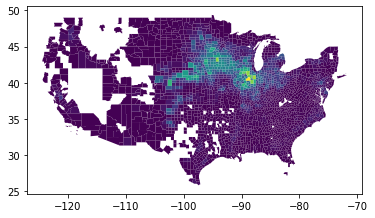

In [7]:
data_counties.plot(column='corn_prod') # mean over all years

<AxesSubplot:>

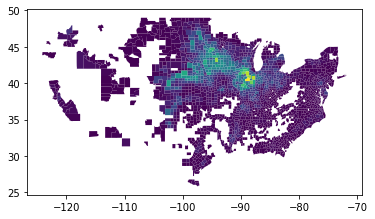

In [15]:
data_counties.plot(column='corn_prod') #>2005

<AxesSubplot:>

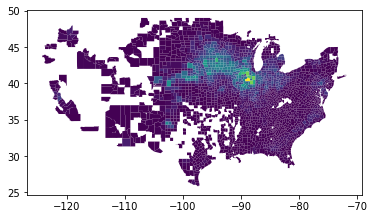

In [17]:
data_counties.plot(column='corn_prod')

## Repairing messsed up counties

To merge: 
   - 51515 --> 51019 (Bedford City into Bedford County; Virginia 2013)
   - 51560 --> 51005 (Clifton Forge into Alleghany county; Virginia 2001)
   - 46113 --> 46102 (Shannon County renamed to Oglala Lakota County; South Dakota 2015)
   - 29193 --> 29186 (Ste. Genevieve County FIPS change in 1979)
    
To ignore: 
   - 15007: Kauai in Hawaii 
  
To merge (https://apps.bea.gov/regional/docs/statelist.cfm): 
   - 51901: 51003 (Albermarle) and 51540 (Charlottesville)
   - 51903: 51005 (Alleghany) 51580 (Covington)
   - 51911: 51031 (Campbell) 51680 (Lynchburg)
   - 51913: 51035 (Carroll) 51640 (Galax)
   - 51921: 51069 (Frederick) 51840 (Winchester)
   - 51923: 51081 (Greensville) 51595 (Emporia)
   - 51929: 51089 (Henry) 51690 (Martinsville)
   - 51931: 51095 (James City) 51830 (Williamsburg)
   - 51933: 51121 (Montgomery) 51750 (Radford)
   - 51939: 51143 (Pittsylvania) 51590 (Danville)
   - 51941: 51149 (Prince George) 51670 (Hopewell)
   - 51944: 51161 (Roanoke) 51775 (Salem)
   - 51947: 51165 (Rockingham) 51660 (Harrisonburg)
   - 51949: 51175 (Southampton) 51620 (Franklin)
   - 51951: 51177 (Spotsylvania) 51630 (Fredericksburg)
   - 51953: 51191 (Washington) 51520 (Bristol)
   - 51955: 51195 (Wise) 51720 (Norton)
   - 51958: 51199 (York) 51735 (Poquoson)
   - 51942: 51685, 51153, 51683 (Prince William, Manassas Park, Manassas)
   - 51945: 51530, 51163, 51678 (Buena Vista, Rockbridge, Lexington)
   - 51918: 51053, 51570, 51730 (Dinwiddie, Colonial Heights, Petersburg)
   - 51907: 51790, 51015, 51820 (Augusta, Staunton, Waynesboro)
   - 51919: 51059, 51600, 51610 (Falls Church, Fairfax, Fairfax City)

## Export

In [16]:
data_counties.to_file(dir_list['geo']+'UScounties_proc.shp')

/home/kschwarz/.conda/envs/iv_impact/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [3]:
import xarray as xr
import glob
import os

In [5]:
remap_key_fix = {**remap_key,
                '51019':['51019'],
                '51560':['51005'],
                '46102':['46102'],
                '29186':['29193']}

# reverse map key to show which county idxs in the files should be mapped 
# to which gdp pc 
rem_counties = [v for k,v in remap_key_fix.items()]
fix_counties = [k for k in remap_key_fix]
torem_counties = [item for sublist in rem_counties for item in sublist]

remap_key_fix = {c:fix_counties[np.where([c in cs for cs in rem_counties])[0][0]] for c in torem_counties}

In [15]:
fns = dict()
#['dyield','dgdp-pp','dmort']
for v in ['dmort']:
    fns[v] = glob.glob('/Volumes/KSssd/climate_data/ERA-INTERIM/'+v+'_tot*.nc')
    
    for fn in fns[v]:
        ds = xr.open_dataset(fn)
        # Just use the gdp2015 as the nan mask - since corn prod can be 
        # nan everywhere it's 0 
        fips_list = ds.isel(county_idx = np.isnan(ds['gdp2015'])).FIPS.values

        for v2 in ['tpop','gdp2015','corn_prod','gdp_pp']:
            if 'gdp_pp' not in ds:
                ds['gdp_pp'] = ds['gdp2015'] / ds['tpop']
            for fips in fips_list:
                # Add missing values
                ds[v2].loc[{'county_idx':(ds.FIPS==str(fips))}] = np.array(data_counties.loc[data_counties.FIPS==remap_key_fix[str(fips)]][v2])[0]

        # Say what you did
        ds.attrs['DESCRIPTION2'] = 'edited to add missing tpop/gdp values for Virginian combined counties, using create_data_counties.ipynb'
        
        # Save 
        os.remove(fn)
        ds.to_netcdf(fn)
        print(fn+' saved!')

/Volumes/KSssd/climate_data/ERA-INTERIM/dmort_tot_CanESM2-LE_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc saved!
/Volumes/KSssd/climate_data/ERA-INTERIM/dmort_tot_CanESM2-LE_rcp85_hist-midc-endc_bycounty_CUSA.nc saved!
/Volumes/KSssd/climate_data/ERA-INTERIM/dmort_tot_CESM1-CAM5-LE_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc saved!
/Volumes/KSssd/climate_data/ERA-INTERIM/dmort_tot_CESM1-CAM5-LE_rcp85_hist-midc-endc_bycounty_CUSA.nc saved!
/Volumes/KSssd/climate_data/ERA-INTERIM/dmort_tot_CSIRO-Mk3-6-0-LE_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc saved!
/Volumes/KSssd/climate_data/ERA-INTERIM/dmort_tot_CSIRO-Mk3-6-0-LE_rcp85_hist-midc-endc_bycounty_CUSA.nc saved!
/Volumes/KSssd/climate_data/ERA-INTERIM/dmort_tot_CSIRO-Mk3-6-0_rcp26_hist-begc-midc-endc_bycounty_CUSA.nc saved!
/Volumes/KSssd/climate_data/ERA-INTERIM/dmort_tot_CSIRO-Mk3-6-0_rcp45_hist-begc-midc-endc_bycounty_CUSA.nc saved!
/Volumes/KSssd/climate_data/ERA-INTERIM/dmort_tot_CSIRO-Mk3-6-0_rcp60_hist-begc-midc-endc_bycounty_CUSA

In [4]:
ds = xr.open_dataset('/Volumes/KSssd/climate_data/ERA-INTERIM/dmort_tot_CanESM2-LE_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc')

In [10]:
ds.isel(county_idx = ds.FIPS=="51942")

<xarray.Dataset>
Dimensions:        (county_idx: 0, run: 50)
Coordinates:
  * county_idx     (county_idx) int64 
  * run            (run) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
Data variables: (12/13)
    STATEFP        (county_idx) object 
    FIPS           (county_idx) object 
    NAME           (county_idx) object 
    tpop           (county_idx) float64 
    gdp2015        (county_idx) float64 
    corn_prod      (county_idx) float64 
    ...             ...
    dimp_begc      (county_idx, run) float64 
    dimp_midc      (county_idx, run) float64 
    dimp_endc      (county_idx, run) float64 
    sum_dimp_begc  (run) float64 2.752e+03 603.9 -1.233e+03 ... -1.386e+03 528.2
    sum_dimp_midc  (run) float64 6.483e+03 7.974e+03 ... 9.49e+03 6.905e+03
    sum_dimp_endc  (run) float64 2.665e+04 2.844e+04 ... 2.907e+04 2.59e+04
Attributes:
    SOURCE:        wrapper_bin_dmgf()
    DESCRIPTION:   full damages calculated by county for heat-related mortali...
    DESCRIPTION2:  edited to add missing tpop/gdp values for Virginian combin...